In [1]:
%autoreload 2

from VMTest import *

In [28]:
def removeAuthors(df):
    skipAuthors = loadSQL('skipAuthors','reference')['0']
    subset = df[~df['author'].isin(skipAuthors)].copy()
    
    return subset

def getAuthorCounts(char, skipAuthors=False):
    df = loadSQL(char, database_name, index_col='index')
    counts = df.groupby('subreddit')['author'].count()
    counts.name = char
    
    return counts

def getCommentCounts(char, skipAuthors=False):
    df = loadSQL(char, database_name, index_col='index')
    if skipAuthors:
        df = removeAuthors(df)
    counts = df.groupby('subreddit')['weight'].sum()
    counts.name = char
    
    return counts

def getTotal(countsList):
    totals = pd.concat(countsList, axis=1)
    totals.index.name = 'subreddit'
    totals['TOTAL'] = totals.sum(axis=1)
    totals.sort_values('TOTAL', ascending=False, inplace=True)
    
    return totals

def getCommentTotals():
    database_name = 'allEdges'
    completed = checkCompleted(database_name)
    engine = get_engine(database_name)

    dfs = []
    for char in completed:
        query = """
        SELECT author, subreddit, weight FROM '{0}'
        WHERE (author in
                    (SELECT author FROM '{0}'
                    WHERE (subreddit == '{1}') and
                            (weight > 2)))
            and (weight > 2)
        """.format(char, subreddit)

        data = pd.read_sql_query(query, engine)
        dfs.append(data)
    df = pd.concat(dfs)
        
    return df

def getSubredditNetwork(subreddit):
    database_name = 'allEdges'
    completed = checkCompleted(database_name)
    engine = get_engine(database_name)

    dfs = []
    for char in completed:
        query = """
        SELECT author, subreddit, weight FROM '{0}'
        WHERE (author in
                    (SELECT author FROM '{0}'
                    WHERE (subreddit == '{1}') and
                            (weight > 2)))
            and (weight > 2)
        """.format(char, subreddit)

        data = pd.read_sql_query(query, engine)
        dfs.append(data)
    df = pd.concat(dfs)
        
    return df

def getCommentCounts(subreddit):
    data = getSubredditNetwork(subreddit)
    subset = removeAuthors(data)
    counts = subset.groupby('subreddit')['weight'].sum().sort_values(ascending=False)
    
    return counts

In [ ]:
database_name = 'allEdges'
completed = checkCompleted(database_name)

commentCounts = []

for char in completed:
    counts = getCommentCounts(char, skipAuthors=True)
    commentCounts.append(counts)
    
totals = getTotal(commentCounts)
totalRank= totals['TOTAL'].reset_index().reset_index()
cols = ['rank','subreddit','weight']
totalRank.columns = cols

totalRank.head()

In [14]:
defaults = loadSQL('defaults','reference')
defaults = defaults.defaults.unique()

In [263]:
subreddit = 'changemyview'
counts = getCommentCounts('changemyview')
rank = counts.reset_index().reset_index()
rank.columns = cols

In [290]:
def getRankComparison(rank):
    m = pd.merge(rank, totalRank, on='subreddit', suffixes=('','Total'), how='outer').fillna(0)
    m['rankDiff'] = (m['rankTotal']+1)-m['rank'] # +1 discounts subreddit in first position
    m['ratio'] = (m['weight'])/m['weightTotal'] # +1 for missing subreddits
    
    return m

cmv = getRankComparison(rank)
cmv.head()

,rank,subreddit,weight,rankTotal,weightTotal,rankDiff,ratio
0,0.0,changemyview,89265.0,126,100706.0,127.0,0.886392
1,1.0,AskReddit,71396.0,0,4900515.0,0.0,0.014569
2,2.0,politics,28032.0,1,1746096.0,0.0,0.016054
3,3.0,news,15865.0,5,717183.0,3.0,0.022121
4,4.0,worldnews,13930.0,4,739256.0,1.0,0.018843


In [266]:
missing = cmv[cmv['weight']==0]
missing.head()

,rank,subreddit,weight,rankTotal,weightTotal,rankDiff,ratio
5626,0.0,u_RedditNintendoSwitch,0.0,260,56927.0,261.0,0.0
5627,0.0,kpop,0.0,395,38247.0,396.0,0.0
5628,0.0,CampHalfBloodRP,0.0,508,30637.0,509.0,0.0
5629,0.0,RepLadies,0.0,572,26476.0,573.0,0.0
5630,0.0,TrueFMK,0.0,575,26310.0,576.0,0.0


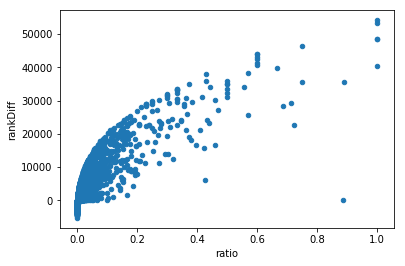

In [268]:
cmv[cmv['ratio']>0].plot('ratio','rankDiff',kind='scatter');

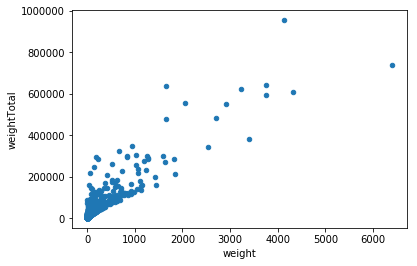

In [269]:
underindexed = cmv[cmv['rankDiff']<0]

underindexed.plot('weight','weightTotal',kind='scatter')

In [270]:
underindexed.head()

,rank,subreddit,weight,rankTotal,weightTotal,rankDiff,ratio
8,8.0,The_Donald,6388.0,3,740127.0,-4.0,0.008631
15,15.0,funny,4320.0,9,610233.0,-5.0,0.007079
17,17.0,nba,4135.0,2,954339.0,-14.0,0.004333
20,20.0,nfl,3755.0,6,642015.0,-13.0,0.005849
21,21.0,gaming,3751.0,10,594125.0,-10.0,0.006313


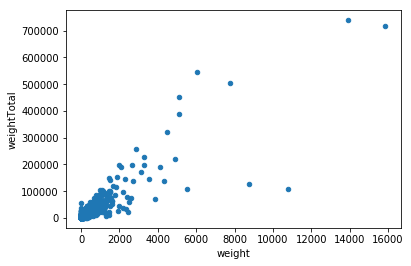

In [293]:
overindexed = cmv[(cmv['rankDiff']>0)&(cmv['subreddit']!=subreddit)]
overindexed.plot('weight','weightTotal',kind='scatter');

In [304]:
cmv.sort_values('zratio').tail(50)

,rank,subreddit,weight,rankTotal,weightTotal,rankDiff,ratio,zratio
4180,4180.0,RevisionistHistoryPod,5.0,32417,14.0,28238.0,0.357143,22.222300
4239,4239.0,hbomberguy,5.0,33239,14.0,29001.0,0.357143,22.222300
4564,4564.0,unjerkgaming,4.0,35483,11.0,30920.0,0.363636,22.627732
2855,2855.0,WriteDontWrite,12.0,24016,33.0,21162.0,0.363636,22.627732
3709,3709.0,asktouhouscience,7.0,29570,19.0,25862.0,0.368421,22.926472
2482,2482.0,MegaGames,16.0,21581,43.0,19100.0,0.372093,23.155738
5443,5443.0,NoAdmins,3.0,40584,8.0,35142.0,0.375000,23.337240
2256,2256.0,thebayesianconspiracy,19.0,20324,50.0,18069.0,0.380000,23.649423
4148,4148.0,PhillipDeFranco,5.0,33865,13.0,29718.0,0.384615,23.937592
1970,1970.0,evopsych,25.0,18513,63.0,16544.0,0.396825,24.699945


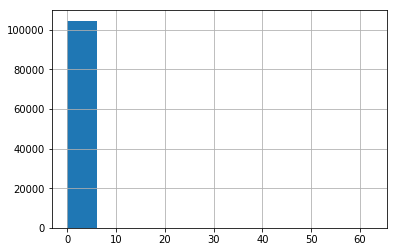

In [299]:
overindexed.zratio.hist()

In [292]:
from scipy.stats import zscore

cmv['zratio'] = zscore(cmv.ratio)

In [291]:
zscore(cmv['ratio'])

array([ 55.26685122,   0.83313821,   0.92585783, ...,  -0.07650651,
        -0.07650651,  -0.07650651])

In [285]:
cmv.head()

,rank,subreddit,weight,rankTotal,weightTotal,rankDiff,ratio,zratio
0,0.0,changemyview,89265.0,126,100706.0,127.0,0.886392,NaN
1,1.0,AskReddit,71396.0,0,4900515.0,0.0,0.014569,NaN
2,2.0,politics,28032.0,1,1746096.0,0.0,0.016054,NaN
3,3.0,news,15865.0,5,717183.0,3.0,0.022121,NaN
4,4.0,worldnews,13930.0,4,739256.0,1.0,0.018843,NaN


In [287]:
zscore(cmv.ratio)

array([ nan,  nan,  nan, ...,  nan,  nan,  nan])

In [288]:
cmv.ratio

0         0.886392
1         0.014569
2         0.016054
3         0.022121
4         0.018843
5         0.099153
6         0.068199
7         0.015414
8         0.008631
9         0.011110
10        0.051862
11        0.013108
12        0.011245
13        0.022215
14        0.014006
15        0.007079
16        0.031552
17        0.004333
18        0.021490
19        0.053950
20        0.005849
21        0.006313
22        0.024394
23        0.008911
24        0.016617
25        0.014417
26        0.005187
27        0.018091
28        0.005276
29        0.011069
            ...   
106657         NaN
106658         NaN
106659         NaN
106660         NaN
106661         NaN
106662         NaN
106663         NaN
106664         NaN
106665         NaN
106666         NaN
106667         NaN
106668         NaN
106669         NaN
106670         NaN
106671         NaN
106672         NaN
106673         NaN
106674         NaN
106675         NaN
106676         NaN
106677         NaN
106678      

In [289]:
cmv.zratio.describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: zratio, dtype: float64

In [305]:
from VMTest import projection_fast as project

In [307]:
df = getSubredditNetwork(subreddit)
df.head()

,author,subreddit,weight
0,AutoModerator,onewordeach,52
1,AutoModerator,ModelNortheastChamber,31
2,alea6,CasualConversation,20
3,AutoModerator,KotakuInAction,335
4,AutoModerator,OldManDog,81


In [308]:
subset = removeAuthors(df)
subset.head()

,author,subreddit,weight
2,alea6,CasualConversation,20
6,anoiing,AdviceAnimals,99
17,Ascimator,Parahumans,27
24,aldjfh,Braincels,39
28,Amicus-Regis,EDH,72


In [311]:
node_stats = project(subset)
node_stats.head()

,core_number,degree,degree_centrality
0xProject,4,4,0.000711
100movies365days,8,8,0.001422
1200isplenty,1365,1748,0.310756
13451452251849519,27,27,0.004800
13ReasonsWhy,31,31,0.005511


In [324]:
node_stats.sort_values('degree', ascending=False, inplace=True)

In [316]:
database_name = 'allEdges'
completed = checkCompleted(database_name)
engine = get_engine(database_name)

dfs = []
for char in completed:
    print(char)
    query = """
    SELECT author, subreddit, weight FROM '{0}'
    WHERE (weight > 2)
    """.format(char)

    data = pd.read_sql_query(query, engine)
    subset = removeAuthors(data)
    dfs.append(subset)
allEdges = pd.concat(dfs)

a
b
c
d
e
f
g
h
i
j
k
l
m
n
o
p
q
r
s
t
u
v
w
x
y
z
0
1
2
3
4
5
6
7
8
9


In [319]:
allEdges.max()

author       zzzzzzzzzzzzzzzzspaf
subreddit                    zyzz
weight                      40438
dtype: object

In [320]:
full_node_stats = project(allEdges)
full_node_stats.head()

,core_number,degree,degree_centrality
03103108xxx,16,16,0.000383
07Scape,14,14,0.000335
0ad,2,2,0.000048
0b0t,0,0,0.000000
0xProject,1621,1821,0.043612


In [322]:
full_node_stats.sort_values('degree', ascending=False, inplace=True)
full_node_stats.head()

,core_number,degree,degree_centrality
AskReddit,1621,21326,0.510741
funny,1621,14424,0.345444
pics,1621,14082,0.337253
todayilearned,1621,13923,0.333445
worldnews,1621,13629,0.326404


In [325]:
node_stats.head()

,core_number,degree,degree_centrality
changemyview,1365,5625,1.000000
AskReddit,1365,4562,0.811022
todayilearned,1365,3558,0.632533
worldnews,1365,3388,0.602311
news,1365,3334,0.592711


In [326]:
ns = pd.merge(node_stats, full_node_stats, left_index=True, right_index=True, how='inner', suffixes=['CMV','Total'])
ns.head()

,core_numberCMV,degreeCMV,degree_centralityCMV,core_numberTotal,degreeTotal,degree_centralityTotal
changemyview,1365,5625,1.000000,1621,5625,0.134714
AskReddit,1365,4562,0.811022,1621,21326,0.510741
todayilearned,1365,3558,0.632533,1621,13923,0.333445
worldnews,1365,3388,0.602311,1621,13629,0.326404
news,1365,3334,0.592711,1621,13072,0.313064


In [327]:
ns['dcRatio'] = ns['degree_centralityCMV']/ns['degree_centralityTotal']
ns.head()

,core_numberCMV,degreeCMV,degree_centralityCMV,core_numberTotal,degreeTotal,degree_centralityTotal,dcRatio
changemyview,1365,5625,1.000000,1621,5625,0.134714,7.423111
AskReddit,1365,4562,0.811022,1621,21326,0.510741,1.587932
todayilearned,1365,3558,0.632533,1621,13923,0.333445,1.896964
worldnews,1365,3388,0.602311,1621,13629,0.326404,1.845293
news,1365,3334,0.592711,1621,13072,0.313064,1.893257


In [328]:
ns['dcRatio'].describe()

count    5626.000000
mean        1.696138
std         1.868276
min         0.003280
25%         0.246101
50%         0.866030
75%         2.683001
max         7.423111
Name: dcRatio, dtype: float64

In [332]:
ns['degreeRatio'] = ns['degreeCMV']/ns['degreeTotal']

In [336]:
ns.sort_values(['degreeRatio', 'degreeCMV'], ascending=[False, False]).head(20)

,core_numberCMV,degreeCMV,degree_centralityCMV,core_numberTotal,degreeTotal,degree_centralityTotal,dcRatio,degreeRatio
changemyview,1365,5625,1.000000,1621,5625,0.134714,7.423111,1.0
u_Bharat02,1365,1365,0.242667,1365,1365,0.032691,7.423111,1.0
u_funktown7779,1365,1365,0.242667,1365,1365,0.032691,7.423111,1.0
ToyControl,793,793,0.140978,793,793,0.018992,7.423111,1.0
jobbit,793,793,0.140978,793,793,0.018992,7.423111,1.0
SP7CircleJerk,793,793,0.140978,793,793,0.018992,7.423111,1.0
DebateConservatives,793,793,0.140978,793,793,0.018992,7.423111,1.0
DeutscheEishockeyLiga,793,793,0.140978,793,793,0.018992,7.423111,1.0
My_Perverted_Stories,793,793,0.140978,793,793,0.018992,7.423111,1.0
u_nguyenhahai572341,793,793,0.140978,793,793,0.018992,7.423111,1.0


In [337]:
ns.head(20)

,core_numberCMV,degreeCMV,degree_centralityCMV,core_numberTotal,degreeTotal,degree_centralityTotal,dcRatio,degreeRatio
changemyview,1365,5625,1.000000,1621,5625,0.134714,7.423111,1.000000
AskReddit,1365,4562,0.811022,1621,21326,0.510741,1.587932,0.213917
todayilearned,1365,3558,0.632533,1621,13923,0.333445,1.896964,0.255548
worldnews,1365,3388,0.602311,1621,13629,0.326404,1.845293,0.248588
news,1365,3334,0.592711,1621,13072,0.313064,1.893257,0.255049
politics,1365,3272,0.581689,1621,12708,0.304347,1.911270,0.257476
pics,1365,3155,0.560889,1621,14082,0.337253,1.663110,0.224045
funny,1365,3021,0.537067,1621,14424,0.345444,1.554716,0.209443
Showerthoughts,1365,2907,0.516800,1621,11445,0.274099,1.885451,0.253997
gaming,1365,2855,0.507556,1621,13550,0.324512,1.564058,0.210701


In [340]:
ns.core_numberTotal.unique().shape

(1143,)

In [352]:
core_unique, core_indices = sp.unique(ns.core_numberCMV, return_inverse=True)
ns['core_indicesCMV'] = core_indices

In [350]:
core_unique, core_indices = sp.unique(ns.core_numberTotal, return_inverse=True)
ns['core_indicesTotal'] = core_indices

In [353]:
ns.head()

,core_numberCMV,degreeCMV,degree_centralityCMV,core_numberTotal,degreeTotal,degree_centralityTotal,dcRatio,degreeRatio,core_indicesTotal,core_indicesCMV
changemyview,1365,5625,1.000000,1621,5625,0.134714,7.423111,1.000000,1142,263
AskReddit,1365,4562,0.811022,1621,21326,0.510741,1.587932,0.213917,1142,263
todayilearned,1365,3558,0.632533,1621,13923,0.333445,1.896964,0.255548,1142,263
worldnews,1365,3388,0.602311,1621,13629,0.326404,1.845293,0.248588,1142,263
news,1365,3334,0.592711,1621,13072,0.313064,1.893257,0.255049,1142,263


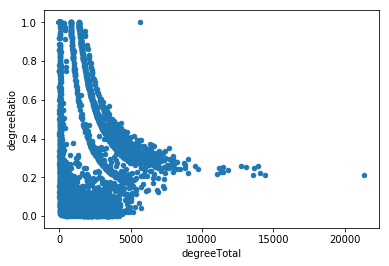

In [362]:
def scatter(df, x, y):
    df.plot(x, y, kind='scatter');
    
scatter(ns, 'degreeTotal', 'degreeRatio')

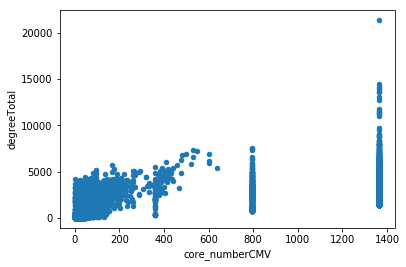

In [365]:
scatter(ns, 'core_numberCMV','degreeTotal')

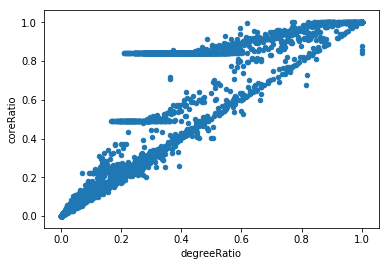

In [379]:
scatter(ns, 'degreeRatio','coreRatio')

In [371]:
ns.core_numberCMV.unique()

array([1365,  793,  637,  602,  550,  531,  519,  483,  429,  499,  460,
        468,  418,  475,  442,  404,  478,  409,  432,  437,  397,  400,
        440,  430,  413,  417,  414,  401,  399,  389,  382,  346,  381,
        391,  320,  392,  334,  384,  385,  387,  335,  377,  378,  373,
        306,  376,  291,  372,  364,  290,  358,  324,  359,  265,  256,
        258,  261,  260,  270,  262,  249,  263,  254,  228,  241,  246,
        233,  235,  190,  207,  234,  197,  230,  216,  210,  204,  215,
        209,  225,  208,  203,  222,  187,  196,  195,  214,  192,  199,
        191,  198,  184,  186,  170,  185,  171,  176,  180,  183,  155,
        169,  173,  157,  153,  165,  163,  166,  167,  152,  168,  162,
        164,  145,  178,  160,  148,  179,  147,  150,  137,  146,  141,
        149,  151,  129,  140,  126,  142,  138,  131,  130,  143,  135,
        139,  132,  134,  118,  136,  144,  125,  120,  128,  121,  124,
        119,  113,  122,  116,  127,  117,  109,  1

In [378]:
ns['coreRatio']=ns['core_numberCMV']/ns['core_numberTotal']
ns.head()

,core_numberCMV,degreeCMV,degree_centralityCMV,core_numberTotal,degreeTotal,degree_centralityTotal,dcRatio,degreeRatio,core_indicesTotal,core_indicesCMV,relDegreeRatio,coreRatio
changemyview,1365,5625,1.000000,1621,5625,0.134714,7.423111,1.000000,1142,263,3.949266,0.842073
AskReddit,1365,4562,0.811022,1621,21326,0.510741,1.587932,0.213917,1142,263,0.844816,0.842073
todayilearned,1365,3558,0.632533,1621,13923,0.333445,1.896964,0.255548,1142,263,1.009229,0.842073
worldnews,1365,3388,0.602311,1621,13629,0.326404,1.845293,0.248588,1142,263,0.981739,0.842073
news,1365,3334,0.592711,1621,13072,0.313064,1.893257,0.255049,1142,263,1.007256,0.842073
